# Time Series Prediction

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.callbacks import EarlyStopping
import json

Using TensorFlow backend.


## Read in Data

In [2]:
# Read in feature data
with open('feature_database.json') as json_database:
    database = json.load(json_database)
# Concat data
feature_data = None
for i in database:
    # Filter emission data
    if (database[i]['sector'] != 'target_values' and 
        database[i]['sector'] != 'greenhouse_emissions'):
        new_data = pd.read_json(database[i]['data'])
        if feature_data is None:
            feature_data = new_data
        else:
            feature_data = pd.concat([feature_data, new_data], axis=1, join="inner")
    else:
        print(f"Feature not used: {i}")
feature_data = feature_data.values
feature_data = feature_data.astype('float64')
print(f"Shape input features: {feature_data.shape}")

FileNotFoundError: [Errno 2] No such file or directory: 'feature_database.json'

In [213]:
# Read in emission data
emission_data = pd.read_csv(
    "oeko-institut_sektorale_abgrenzung_treibhausgasemissionen_daten_sektor_monthly.csv")
emission_data = emission_data['Total_CO2_Emission'].values
emission_data = emission_data.astype('float64')
# Take only the emissions on which we have indicators
emission_data = emission_data[len(emission_data)-feature_data.shape[0]:]
print(f"Shape output data: {emission_data.shape}")

Shape output data: (110,)


In [214]:
# Convert an array of values into a dataset matrix
def sliding_window(input, output, look_back=1, horizon=1, shuffle=False):
	dataX, dataY = [], []
	if len(input) != len(output):
		raise ValueError('Input and ouput do not have same length!')
	for i in range(len(input)-look_back-horizon):
		dataX.append(input[i:(i+look_back)])
		dataY.append(output[(i+look_back):(i+look_back+horizon)])
	# Shuffle windows
	if shuffle is True:
		dataX, dataY = shuffle(dataX, dataY, random_state=0)
	return np.array(dataX), np.array(dataY)

In [215]:
scaler = StandardScaler()
feature_data = scaler.fit_transform(feature_data)

look_back = 12  # months
horizon = 6     # months
split_ratio = 0.8
shuffle = False

# Split into train and test sets
train_size = int(len(feature_data) * split_ratio)
test_size = len(feature_data) - train_size
if test_size < (look_back+horizon):
    raise ValueError('Split ratio too small. Increase test size!')

## Multilayer Perceptron (MLP)

In [216]:
# Regressions forecast model with windowing method
def train_model(trainX, trainY, testX,  testY, lock_back, horizon):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    model = Sequential()
    # Flatten array if input is matrix
    if len(trainX.shape) >= 3:
        model.add(Flatten())
        model.add(Dense(look_back, input_dim=trainX.shape[2]*look_back, activation='relu'))
    model.add(Dense(24, input_dim=look_back, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=400, batch_size=2, verbose=2, callbacks=[es])
    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    testScore = model.evaluate(testX, testY, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

    # Generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    return model, trainPredict, testPredict

## Input: Emissions

### Create Dataset

In [217]:
# Emissions as input
trainX, trainY = sliding_window(emission_data[0:train_size],
                                emission_data[0:train_size],
                                look_back,
                                horizon)
testX, testY = sliding_window(emission_data[train_size:len(emission_data)],
                              emission_data[train_size:len(emission_data)],
                              look_back,
                              horizon)

In [218]:
print("Shape of data:")
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

Shape of data:
(70, 12)
(70, 6)
(4, 12)
(4, 6)


### Train Model

In [219]:
# Create and fit Multilayer Perceptron model for every indicator
trainPredictPlot = np.empty_like(emission_data)
trainPredictPlot[:] = np.nan
testPredictPlot = np.empty_like(emission_data)
testPredictPlot[:] = np.nan

# Train model and generate predictions
model, trainPredict, testPredict = train_model(trainX, trainY, testX, testY,
                                               look_back, horizon)

# Shift train predictions for plotting
for t in range(len(trainPredict)):
    trainPredictPlot[t+look_back:t+look_back+horizon] = trainPredict[t, :]
for t in range(len(testPredict)):
    testPredictPlot[len(trainPredict)+t+look_back+horizon:len(trainPredict)+
                    t+look_back+(horizon*2)] = testPredict[t, :]

Epoch 1/400
 - 0s - loss: 2157.3806
Epoch 2/400
 - 0s - loss: 373.4739
Epoch 3/400
 - 0s - loss: 56.7784
Epoch 4/400
 - 0s - loss: 25.3814
Epoch 5/400
 - 0s - loss: 23.8671
Epoch 6/400
 - 0s - loss: 22.4450
Epoch 7/400
 - 0s - loss: 22.5944


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 8/400
 - 0s - loss: 22.2160
Epoch 9/400
 - 0s - loss: 22.7008
Epoch 10/400
 - 0s - loss: 21.7313
Epoch 11/400
 - 0s - loss: 19.6695
Epoch 12/400
 - 0s - loss: 21.4913
Epoch 13/400
 - 0s - loss: 19.3408
Epoch 14/400
 - 0s - loss: 18.6839
Epoch 15/400
 - 0s - loss: 18.5428
Epoch 16/400
 - 0s - loss: 17.1844
Epoch 17/400
 - 0s - loss: 17.3014
Epoch 18/400
 - 0s - loss: 16.5001
Epoch 19/400
 - 0s - loss: 16.1307
Epoch 20/400
 - 0s - loss: 16.5790
Epoch 21/400
 - 0s - loss: 15.9214
Epoch 22/400
 - 0s - loss: 14.7072
Epoch 23/400
 - 0s - loss: 15.0557
Epoch 24/400
 - 0s - loss: 14.1621
Epoch 25/400
 - 0s - loss: 13.7230
Epoch 26/400
 - 0s - loss: 13.6650
Epoch 27/400
 - 0s - loss: 12.9019
Epoch 28/400
 - 0s - loss: 12.3291
Epoch 29/400
 - 0s - loss: 12.4352
Epoch 30/400
 - 0s - loss: 12.1275
Epoch 31/400
 - 0s - loss: 11.7525
Epoch 32/400
 - 0s - loss: 12.0592
Epoch 33/400
 - 0s - loss: 11.3912
Epoch 34/400
 - 0s - loss: 10.6434
Epoch 35/400
 - 0s - loss: 11.3644
Epoch 36/400
 - 0s - l

### Prediction and Plot

Forecast: [[72.73337  71.396545 68.855255 65.46299  61.842396 59.51041 ]]


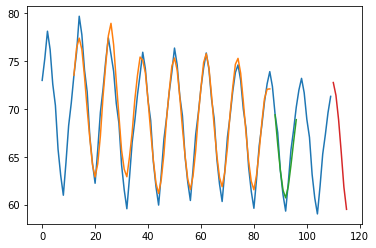

In [220]:
# Forecast predictions
forecastPlot = np.zeros((len(emission_data) + horizon))
forecastPlot[:] = np.nan

X = np.zeros((1, look_back))
X[0] = emission_data[len(emission_data)-look_back:]
predict = model.predict(X)
forecastPlot[len(emission_data):len(emission_data)+horizon] = predict[:]

print(f"Forecast: {predict}")

# Plot baseline, training, test and forecast
plt.plot(emission_data[:])
plt.plot(trainPredictPlot[:])
plt.plot(testPredictPlot[:])
plt.plot(forecastPlot[:])
plt.show()

## Input: Features

### Create Dataset

In [221]:
# Features as input
trainX, trainY = sliding_window(feature_data[0:train_size,:],
                                emission_data[0:train_size],
                                look_back,
                                horizon)
testX, testY = sliding_window(feature_data[train_size:len(feature_data),:],
                              emission_data[train_size:len(emission_data)],
                              look_back,
                              horizon)

In [222]:
print("Shape of data:")
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

Shape of data:
(70, 12, 40)
(70, 6)
(4, 12, 40)
(4, 6)


### Train Model

In [223]:
# Create and fit Multilayer Perceptron model for every indicator
trainPredictPlot = np.empty_like(emission_data)
trainPredictPlot[:] = np.nan
testPredictPlot = np.empty_like(emission_data)
testPredictPlot[:] = np.nan

# Train model and generate predictions
model, trainPredict, testPredict = train_model(trainX, trainY, testX, testY,
                                               look_back, horizon)

# Shift train predictions for plotting
for t in range(len(trainPredict)):
    trainPredictPlot[t+look_back:t+look_back+horizon] = trainPredict[t, :]
for t in range(len(testPredict)):
    testPredictPlot[len(trainPredict)+t+look_back+horizon:len(trainPredict)+
                    t+look_back+(horizon*2)] = testPredict[t, :]

Epoch 1/400
 - 0s - loss: 4713.0674
Epoch 2/400
 - 0s - loss: 4358.5861
Epoch 3/400
 - 0s - loss: 3256.3197
Epoch 4/400
 - 0s - loss: 2300.2227
Epoch 5/400
 - 0s - loss: 1524.0013
Epoch 6/400
 - 0s - loss: 746.5971


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 7/400
 - 0s - loss: 273.9504
Epoch 8/400
 - 0s - loss: 124.8547
Epoch 9/400
 - 0s - loss: 70.3936
Epoch 10/400
 - 0s - loss: 43.1882
Epoch 11/400
 - 0s - loss: 30.8136
Epoch 12/400
 - 0s - loss: 24.9249
Epoch 13/400
 - 0s - loss: 21.5910
Epoch 14/400
 - 0s - loss: 19.9492
Epoch 15/400
 - 0s - loss: 18.6402
Epoch 16/400
 - 0s - loss: 17.5415
Epoch 17/400
 - 0s - loss: 16.6556
Epoch 18/400
 - 0s - loss: 15.8818
Epoch 19/400
 - 0s - loss: 15.1395
Epoch 20/400
 - 0s - loss: 14.3768
Epoch 21/400
 - 0s - loss: 13.6461
Epoch 22/400
 - 0s - loss: 12.9073
Epoch 23/400
 - 0s - loss: 12.2635
Epoch 24/400
 - 0s - loss: 11.1781
Epoch 25/400
 - 0s - loss: 10.2589
Epoch 26/400
 - 0s - loss: 9.2200
Epoch 27/400
 - 0s - loss: 8.1747
Epoch 28/400
 - 0s - loss: 7.2571
Epoch 29/400
 - 0s - loss: 6.4391
Epoch 30/400
 - 0s - loss: 5.6126
Epoch 31/400
 - 0s - loss: 5.0515
Epoch 32/400
 - 0s - loss: 4.7372
Epoch 33/400
 - 0s - loss: 4.4668
Epoch 34/400
 - 0s - loss: 4.1571
Epoch 35/400
 - 0s - loss: 3.9

### Prediction and Plot

Forecast: [[40.835308 42.183064 41.716286 41.360825 40.052853 42.88194 ]]


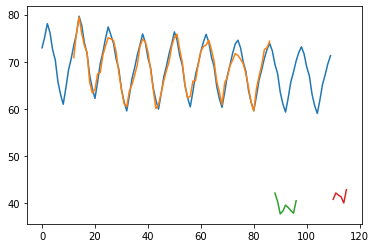

In [224]:
# Forecast predictions
forecastPlot = np.zeros((len(emission_data) + horizon))
forecastPlot[:] = np.nan

# Features
X = np.zeros((1, look_back, feature_data.shape[1]))
X[0] = feature_data[len(feature_data)-look_back:, :]
predict = model.predict(X)
forecastPlot[len(feature_data):len(feature_data)+horizon] = predict[:]

print(f"Forecast: {predict}")

# Plot baseline, training, test and forecast
plt.plot(emission_data[:])
plt.plot(trainPredictPlot[:])
plt.plot(testPredictPlot[:])
plt.plot(forecastPlot[:])
plt.show()